Adrian Kumar - 24573471 - adrian.kumar-1@student.uts.edu.au

# Quantum Algorithm for approximating a Linear Differential Equation (LDE)

This notebook implements the **[quantum LDE solver proposed by Tao Xin](https://arxiv.org/pdf/1807.04553)** for a simple Harmonic Oscillator DE.

## Problem

### Background

Any $n^{th}$ order DE can be represented as a first order vector system in the form:

$$\frac{dv(t)}{dt} = Mv(t) + b$$

where:
* $M$ is an $N\times N$ matrix
* $v(t), \frac{dv(t)}{dt},$ & $b$ are $n$-dimensional vectors

The solution for a differential in this form is exactly:

$$v(t) = e^{Mt}v(0)+(e^{Mt}-I)M^{-1}b$$

~which can be approximated using the taylor series expansion as:

$$v(t) \approx \sum^{k}_{m=0} \frac{(Mt)^{m}}{m!} v(0) + \sum^{k}_{n=1} \frac{M^{n-1}t^{n}}{n!} b$$


The paper aims to generalise this taylor-series expansion into an implementable quantum circuit 

-----------------------------------------------------

### Quantum Algorithm

As a simple overview, the algorithm uses a register of ancilla qubits $|0\rangle^{\otimes T}$ prepared with the Taylor coefficients: $$ \sum^{k}_{m=0} \frac{t^{m}}{m!} $$

~as amplitudes; a *work* register $|\phi\rangle$ is prepared with the initial conditions $v(0), b$, and another ancilla qubit $|0\rangle_{anc}$ holding $|v(0)\rangle, |b\rangle$ in a superposition- with this preparation, controlled powers of a normalised operator $A^{m}$ (entanglement) are applied in a superposition, then interferences recombines all contributions; By measuring $|\phi\rangle$ conditioned on all ancillas being in the zero state $|0\rangle|0\rangle^{\otimes T}$, the remaining subspace encodes a state proportional to the true solution $v(t)$; its amplitudes can then be reconstructed (i.e via quantum state tomography) and rescaled by the known normalisation factor ($N$) to recover the physical solution.

The circuit follows the execution: encode -> entangle -> decode -> measure, as seen below:

![image](circuit.png)

*[See full image here/if image above is not displaying](https://drive.google.com/file/d/1LbTugQO7v2YJHLZ7tyuonv8AdHIb9J8h/view?usp=sharing)*

where the quantum registers represent:
* $|\phi\rangle$ - **Work register** encoding $|v(0)\rangle, |b\rangle$ with $log_{2}(n)$ qubits, where $n$ is the number of dims in $v(0)$
* $|0\rangle_{anc}$ - **Selector ancilla**, a single qubit holding $|v(0)\rangle, |b\rangle$ in superposition
* $|0\rangle^{\otimes T}$ - **Taylor register** holding taylor coefficients as amplitudes with $log_{2}(k+1)$ qubits, where $k$ is the truncation order of the taylor series you want to approximate up to

and the gates:
* $V$ - Puts $|0\rangle_{anc}$ into a superposition
* $V_{S1}, V_{S2}$ - Prepare taylor amplitudes on $|0\rangle^{\otimes T}$
* $U_{v}, U_{b}$ - Prepare initial condition (IC) states $|v(0)\rangle, |b\rangle$
* $U_{k}$ - Entangle the encoding of $M^k, M^{k-1}$ on the full state 
* $W, W_{S1}, W_{S2}$ - Uncompute all ancilla registers (reverse operators of $V, V_{S1}, V_{S2}$)

...while this seems like a lot, leveraging classiq's quantum primitives like `prepare_amplitudes()` or `within_apply` simplify the implementation signficiantly, but the trade off is that some details require modification in order to stay faithful to the paper, and compatible with classiq. (algorithm modifications/design choices will be highlighted throughout the notebook)

-----------------------------------------------------

### Harmonic Oscillator LDE

While the theoretical implementation generalises for any LDE, we still need to precompute components in order to correctly construct, execute and post-process, so the LDE we will be approximating is a simple quantum harmonic oscillator:

$$y^{\prime\prime}+\omega^{2}y=0,$$

$$\text{with } \quad y(0)=1, y^{\prime}(0)=1, \quad \omega=1, \quad t \in [0,1]  $$


with this we can now go forward with breaking down the code implementation!

-----------------------------------------------------


## Project Code

##### Imports

In [1]:
!pip install nbformat>=4.2 #for interactive plot function


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from classiq import *
import numpy as np
import math
import matplotlib.pyplot as plt
from classiq.execution import ExecutionPreferences, ExecutionSession
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from plotly.subplots import make_subplots

authenticate(overwrite=False)

Please visit this URL from any trusted device to authenticate: https://auth.classiq.io/authorize?client_id=f6721qMOVoDAOVkzrv8YaWassRKSFX6Y&response_type=code&audience=https%3A%2F%2Fcadmium-be&redirect_uri=https%3A%2F%2Fauth.classiq.io%2Factivate%3Fuser_code%3DHSRN-XQTC&scope=offline_access
Your user code: HSRN-XQTC


### Pre-Processing (Classical)

The first step is to classically pre-compute the components necessary for the classiq's circuit construction such as our operator, amplitudes and the *known* scaling factor. 

#### True Solution

Our LDE has the solution:
$$y(t) = cos(t)+sin(t)$$
$$y^{\prime}(t) = cos(t) - sin(t)$$

We use this for our baseline comparison on accuracy

In [45]:
y = lambda t: np.cos(t) + np.sin(t) 
y_prime = lambda t: np.cos(t) - np.sin(t)

#### Operator

Putting our LDE into the form $\frac{dv(t)}{dt}=Mv(t)+b$ we can solve for $M$:

$$
\underbrace{
\begin{bmatrix}
y^{\prime}(t) \\[4pt]
y^{\prime\prime}(t)
\end{bmatrix}
}_{v^{\prime}(t)}
=
M
\underbrace{
\begin{bmatrix}
y(t) \\[4pt]
y^{\prime}(t)
\end{bmatrix}
}_{v(t)}
$$

substituting with our LDE, notice that:

$$
y'' + \omega^2 y = 0
\;\xRightarrow{\omega = 1}\;
y'' + y = 0
\;\xRightarrow{}\;
y'' = -y
$$

then we can re-write the expression as:
$$
\begin{bmatrix}
y^{\prime}(t) \\[4pt]
-y(t)
\end{bmatrix}
=
M
\begin{bmatrix}
y(t) \\[4pt]
y^{\prime}(t)
\end{bmatrix}
$$

$M$ is then:
$$M =\begin{bmatrix} 0&1 \\ -1&0 \end{bmatrix}$$


We use this to construct our operator $A$, that encodes $M$ in the circuit as: 

$$A = \frac{M}{\lambda}, \quad \text{where } \lambda = ||M||$$


In [46]:
#system matrix
M = np.array([[0, 1],
              [-1, 0]], dtype=float)

lambduh = float(np.linalg.norm(x=M, ord=2)) #l2norm for M (||M||)
A = M / lambduh 

#### Initial conditions

Our initial conditions are $y(0)=1, y^{\prime}(0)=1$ with $b = 0$, so in vector form:
$$v(0) = \begin{bmatrix} 1 \\ 1 \end{bmatrix}, \quad b = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$


-----

*Design choice: the variable `b_active` conditions the circuit to construct with/without preperation of the $|b\rangle$ branch, saving qubit and gate resources when $b=0$, which it is in our case; however, tuning `b` to be non-zero will construct the circuit with the full two-branch superposition $|v(0)\rangle, |b\rangle$*

In [47]:
v0 = np.array([1, 1], dtype=float) #initial conditions
b = np.array([0, 0], dtype=float) #external state, which is b = 0 in this case
b_active = True if np.linalg.norm(b) != 0 else False #using norm of b as condition

#### State Norms

Here we define 3 scalar quantities:
$$C = ||v(0)||_{2}, \quad D = ||b||_{2}, \quad N=\sqrt{C^{2}+D^{2}}$$

These norms describe the relative magnitudes of the state (based on our initial conditions), used to initialise the circuit. $C$ and $D$ set the scaling of the $|v(0)\rangle$ and $|b\rangle$ branches, while $N$ ensures the selector qubit prepares a properly normalised superposition between them.

-----

*Design choice/Algorithm modification: In the paper, $C$ and $D$ are calculated as:*
$$C = ||v(0)||_{2} \sqrt{\sum_{m} |c^{(v)}_{m}(t)|^{2}}, \quad D = ||b||_{2} \sqrt{\sum_{m} |c^{(b)}_{m}(t)|^{2}}$$

*but this is assuming you compute the **probabilities** of the taylor coefficients rather than their **probability amplitudes**. In classiq we can leverage [prepare_amplitudes()](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/allocation/?h=#classiq.qmod.builtins.functions.allocation.prepare_amplitudes), so we classically compute them for preparing $|0\rangle^{\otimes T}$, which already absolves $\sqrt{\sum_{m} |c_{m}(t)|^{2}}$ directly*

In [48]:
#helper function to normalise vector
def normalise_vector(v):
    norm = np.linalg.norm(v)

    if norm == 0:
        normalised_v = np.zeros_like(v) #just return 0 vector, i.e b = 0 so this case applies 

    else: 
        normalised_v = v / norm 

    n_qubits = int(np.ceil(np.log2(len(v)))) if len(v) > 1 else 1

    return normalised_v, float(norm), n_qubits, #returns normalised vector, the normalising factor and the number of qubits

#returns selector magnitudes (C, D) and their combined normalization N
#paper convention: if the taylor-index register is loaded with raw coefficients c_m, then
# C = ||v(0)|| * sqrt(sum_m |c_m^(v)(t)|^2) and D = ||b|| * sqrt(sum_m |c_m^(b)(t)|^2)
#implementation choice here: get_taylor_amplitudes_* already absorbs sqrt(S_•(t)) factors by normalizing each branch’s coefficient vector,
# so the selector only needs the state norms C = ||v(0)|| and D = ||b||; N = sqrt(C**2 + D**2)

def get_selector_qubit_weights(v0, b): #makes coeffs needed for selector superposition V
    _, C, _ = normalise_vector(v0)
    _, D, _ = normalise_vector(b)
    N = float(np.sqrt(C**2 + D**2))
    return C, D, N 

#### Taylor Amplitudes

We are approximating:

$$v(t) \approx \sum^{k}_{m=0} \frac{(\lambda t)^{m}}{m!} A^{m} v(0) +\sum^{k}_{m=1} \frac{(\lambda t)^{m}}{m! \lambda} A^{m-1} b \quad (\text{if } b \neq 0)$$

For each branch ($v(0), b$), we build the **raw coefficient vectors**:
$$c^{(v)}(t) = [c_0,..., c_k], \quad c_m= \frac{(\lambda t)^{m}}{m!},$$

$$c^{(b)}(t) = [0, \frac{(\lambda t)^{1}}{1!\lambda},..., \frac{(\lambda t)^{k}}{k!\lambda}]$$

then form **probability amplitudes** by $l_2$-normalising:
$$\vec{c}^{(v)} = \frac{c^{(v)}}{||c^{(v)}||_{2}}, \quad \vec{c}^{(b)} = \frac{c^{(b)}}{||c^{(b)}||_{2}}$$

*Normalising the lists means the quantum state carries the shape of the series, not its overall magnitude*


These amplitude lists are loaded onto $|0\rangle^{\otimes T}$ *(where $T = \log_{2}(k+1) $)* using `prepare_amplitudes()`. 
If $2^{T} > k + 1$, then we pad with trailing zeros to get length $2^{T}$ (which does not affect the norm).


------------

*Design choice/Algorithm modification: This step is cruical as it influences the norm factors used for rescaling the circuit output to reconstruct the solution. After measuring the success subspace (all ancillas in $|0\rangle$ state), the work register $|\phi \rangle$ encodes the normalised direction of $v(t)$*, then:
* *If **only one branch** (either $v(0)=0 \text{ or } b=0$) contributes, the post-selected state is normalised by its respective state norms ($C \text{ or } D$), not $N$*
* *if **both branches** contribute coherently, the post-selected state is normalised by $N$*
* *In our instance where $b=0\xRightarrow{}D=0$, we scale by $C$*

In [49]:
weights = lambda t, lam, m: ((lam * t)**m) / math.factorial(m) #defining weights helper from appendix A-3, step 1 in document, 

#taylor amplitudes already normalised, but can also use raw coeffs
def get_taylor_amplitudes_v_branch(t, k, lam):
    #unnormalised coeffs for v branch 
    coeffs = np.array([weights(t, lam, m) for m in range(k + 1)], dtype=float) #appendix A-3, step 1 
    scale = np.sqrt(np.sum(coeffs**2)) if np.sum(coeffs**2) != 0 else 1.0 #appendix A-3, step 2; modified, this returns probability amplitudes for classiq state-prep while appendix showed Probabilities 

    prob_amplitudes = coeffs / scale #appendix A-3, step 3

    return prob_amplitudes, coeffs #normalised prob amps and raw coeffs

def get_taylor_amplitudes_b_branch(t, k, lam):
    coeffs = np.zeros(k+1, dtype=float) #appendix A-3, step 1, with first element being 0

    #appendix A-3, step 1, calculating weights w first element as 0
    for m in range(1, k+1):
        coeffs[m] = (weights(t, lam, m) * 1/max(lam, 1e-12))
    
    scale = np.sqrt(np.sum(coeffs**2)) if np.sum(coeffs**2) != 0 else 1.0 #l2 norm for prob amplitudes, not probabilities; which was initially coeffs.sum() if coeffs.sum() != 0 else 1.0 (same as v branch one)

    prob_amplitdues = coeffs / scale 

    return prob_amplitdues, coeffs #normalised prob amps and raw coeffs

#pads v and b taylor amplitude lists with trailing zeros to match 2**taylor_qubits length
def pad_taylor_amplitudes(unpadded_v_taylor_amps, unpadded_b_taylor_amps, taylor_qubits):
    #compute required length from qubit count
    target_len = 1 << taylor_qubits

    #assume they are already lists as input
    v = unpadded_v_taylor_amps
    b = unpadded_b_taylor_amps

    #pad with zeros if shorter than target_len
    if len(v) < target_len:
        v = v + [0.0] * (target_len - len(v))
    if len(b) < target_len:
        b = b + [0.0] * (target_len - len(b))

    #return padded lists without renormalising to preserve l2 scaling used during amplitude prep
    return v, b

### Quantum Algorithm

With the helper functions and variables defined classically above, we can set up our experiment variables and implement the circuit.

#### Experiment set up & validation

In [50]:
#experimental settings 
k = 8 #taylor trunaction order for approximation 
approximation_points = 10 #to sweep over different t values
t = np.linspace(0, 1, approximation_points)
bounds = np.array([0.0, 1e-3, 1e-2, 5e-2, 0.1, 0.25, 0.5]) #for bounds experiment
curr_bound = bounds[0] #global common bound for circuit experiment

#derived classical quantities
v0_normalised, v0_norm_factor, work_register_size = normalise_vector(v0) 
b_normalised, b_norm_factor, _ = normalise_vector(b) 

C, D = v0_norm_factor, b_norm_factor 

_, _, N = get_selector_qubit_weights(v0, b) #we don't have to use C and D returned from here since its the same as above

taylor_qubits = int(np.ceil(np.log2(k + 1)))

#taylor amplitudes, set up in a list of length t, so each experiment on different t's already have their amplitudes pre-computed
tv_experiments_amplitudes = [(get_taylor_amplitudes_v_branch(t_now, k, lambduh)) for t_now in t] #tv_experiments[t][x] to access where x==0 gives prob amplitudes and x==1 gives raw coeffs, this is for v branch in circuit
tb_experiments_amplitudes = [(get_taylor_amplitudes_b_branch(t_now, k, lambduh)) for t_now in t] #b branch

t_index = 4 #global t index variable we can update in execution functions later, because classiq's circuit compiles at synthesis time
# is_zero_timestep = False #boolean for applying b taylor amps when t=0.0, because b amps will be all 0 which you cannot prepare

#global variables for taylor amplitudes; because we aim to sweep over to see a curved approx
#and circuit is only initialised with python scope variables at synthesis; so update the global variable
#as you iterate over t = [0,.., approximation_points,.. 1]
unpadded_v_taylor_amps = list(tv_experiments_amplitudes[t_index][0])
unpadded__b_taylor_amps = list(tb_experiments_amplitudes[t_index][0])

#the global variables, zero padded to fit qubit register; ensure to do this in execution function
v_amps, b_amps = pad_taylor_amplitudes(unpadded_v_taylor_amps, unpadded__b_taylor_amps, taylor_qubits)

In [51]:
print("---- classical configuration ----")
print(f"omega = {1}")
print(f"M =\n{M}")
print(f"\n||M||_2 = {lambduh:.6f}")
print(f"\nA = M / lambda =\n{A}")
print("\n")

print("---- initial condition states ----")
print(f"v0 = {v0.tolist()}  |  ||v0|| = {v0_norm_factor:.6f}  |  normalized = {v0_normalised.tolist()}")
print(f"b  = {b.tolist()}  |  ||b||  = {b_norm_factor:.6f}  |  normalized = {b_normalised.tolist()}")
print(f"selector weights: C = {C:.6f}, D = {D:.6f}")
print(f"N = sqrt(C^2 + D^2) = {N:.6f}") #even tho N = C in this case, a slight nudge in B would change this, so scaling by respective norms is still used
print("\n")

print("---- register sizes ----")
print(f"work_register_size = {work_register_size} qubit(s)")
print(f"taylor_qubits = {taylor_qubits} (k = {k})")
print(f"Length of V amplitudes list = {len(v_amps)}  |  Length of B amplitudes list = {len(b_amps)}")
print("\n")

print("---- experiment settings ----")
print(f"approximation_points = {approximation_points}  |  time grid t = {np.round(t, 3).tolist()}")

---- classical configuration ----
omega = 1
M =
[[ 0.  1.]
 [-1.  0.]]

||M||_2 = 1.000000

A = M / lambda =
[[ 0.  1.]
 [-1.  0.]]


---- initial condition states ----
v0 = [1.0, 1.0]  |  ||v0|| = 1.414214  |  normalized = [0.7071067811865475, 0.7071067811865475]
b  = [0.0, 0.0]  |  ||b||  = 0.000000  |  normalized = [0.0, 0.0]
selector weights: C = 1.414214, D = 0.000000
N = sqrt(C^2 + D^2) = 1.414214


---- register sizes ----
work_register_size = 1 qubit(s)
taylor_qubits = 4 (k = 8)
Length of V amplitudes list = 16  |  Length of B amplitudes list = 16


---- experiment settings ----
approximation_points = 10  |  time grid t = [0.0, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.0]


Here we construct the truncated Taylor approximation. The selector qubit $|0\rangle_{anc}$ enables superposition of $|v(0)\rangle$ and $|b\rangle$, the Taylor register indexes each power of $A$, and the work register $|\phi \rangle$ accumulates the evolution through interference (uncompute of ancillas).

The operation follows:

$$|0\rangle_{anc}|0\rangle^{\otimes T}|\phi \rangle \rightarrow \sum_{m} C_{m}|0_{anc}, m\rangle A^{m}|v(0)\rangle + \sum_{n} D_{n}|1_{anc}, n-1\rangle A^n-1|b\rangle$$

* `apply_powers_of_A` - binds the Taylor register to a `QNum` for integer view; then for each $m = 1,..k$, we apply $A^{m}$ on the v-branch and $A^{m-1}$ on the b-branch under the condition `taylor_num==m`

* `prepare_ic` - condiitoned on the selector qubit, it prepares $|v(0)\rangle$ and $|b\rangle$ using amplitude encoding

* `controlled_taylor_amps` - loads normalised Taylor amplitudes $\vec{c}^{(v)}$ and $vec{c}^{(b)}$ onto the Taylor register conditioned on the selector qubit.

* `evolve_to_solution` - Calls `prepare_ic` then `apply_powers_of_A` performing the entangling step within the `within_apply` primitive in `approximator`

---------------
*Design choice/Algorithm modifications*:

* We read out all registers in the system as opposed to reading out only the work register, so post-selection on the success branch is easier

* We use `lambda: None` when $b=0$ to avoid unncessary gate synthesis and invalidity of zero-amplitude states

In [65]:
@qfunc 
def apply_powers_of_A(selector: QBit, taylor_reg: QArray[QBit], work: QBit):

    taylor_num = QNum("taylor_num", size=taylor_qubits)
    bind(taylor_reg, taylor_num) #bind taylor reg to taylor num so indexes |m> represented in qnum match the conditioning for A^m  
    
    #we iterate m=1,..k, because m=0 is just identity on the v-branch
    for m in range(1, k + 1):
        control(
            ctrl=(taylor_num == m),  #index taylor register at m to apply power of m on A
             stmt_block=lambda m=m: control(
                ctrl=selector,  #|1> is b-branch, |0> is v-branch
                stmt_block=lambda m=m: power(exponent=m - 1, stmt_block=lambda: unitary(A, target=work)),  #b-branch applies a^(m-1)
                else_block=lambda m=m: power(exponent=m, stmt_block=lambda: unitary(A, target=work))  #v-branch applies a^m
            )
        )
    
    bind(taylor_num, taylor_reg) #uncomputes taylor num
    
#can leave v0 and b as global factors to initialise because thats our LDE
@qfunc 
def UV(work: QBit):
    inplace_prepare_amplitudes(amplitudes=v0_normalised.tolist(), bound=curr_bound, target=work) 

#this never gets called if b is 0 
@qfunc
def UB(work: QBit):
    inplace_prepare_amplitudes(amplitudes=b_normalised.tolist(), bound=curr_bound, target=work) 

@qfunc
def prepare_ic(selector: QBit, work: QBit):
    control(
        ctrl=selector, #condition on selector for |v(0)> and |b> branch
        stmt_block= (lambda: UB(work)) if b_active else (lambda: None), #if b = 0, then no superposition is needed, so leave callable as None to not use any additional gates
        else_block= lambda: UV(work)
    )

@qfunc 
def evolve_to_solution(selector: QBit, taylor_reg: QArray[QBit], work: QBit):
    prepare_ic(selector, work) #prepare initial conditions 
    apply_powers_of_A(selector, taylor_reg, work) #approximate solution;

    #uncomputation of taylor and selector interfere the solution proportional to the work register

#functions use global pythonic variables, so we update them (classically) before every synthesis of the circuit so
#that it prepares the new values that *_amps holds
@qfunc 
def VS2(taylor_reg: QArray[QBit]):
    inplace_prepare_amplitudes(amplitudes=b_amps, bound=curr_bound, target=taylor_reg)

@qfunc 
def VS1(taylor_reg: QArray[QBit]):
    inplace_prepare_amplitudes(amplitudes=v_amps, bound=curr_bound, target=taylor_reg)

#if b is 0, then VS2 never applies
@qfunc 
def controlled_taylor_amps(selector: QBit, taylor_reg: QArray[QBit]):
    control(
        ctrl=selector, #condition on selector
        stmt_block= lambda: VS2(taylor_reg), #on |1> branch, apply taylor amps for b branch
        else_block= lambda: VS1(taylor_reg) #on |0> branch apply taylor amps for v branch
    )

@qfunc 
def approximator(selector: QBit, work: QBit, taylor_register: Output[QArray[QBit]]):
    #next steps prepare taylor -> prepare IC -> apply powers of A -> uncompute taylor

    allocate(taylor_qubits, taylor_register) #initalise

    within_apply(
        within=lambda: controlled_taylor_amps(selector, taylor_register), #within taylor preperation
        apply= lambda: evolve_to_solution(selector, taylor_register, work) #apply IC and powers of A
    )
    #taylor gets uncomputed here

#if b = 0, then D = 0 then D/N = 0, so no b branch is not expected, then selector superposition holds no b contributions
@qfunc 
def V_gate(selector: QBit):
    inplace_prepare_amplitudes(amplitudes=[C/N, D/N], bound=curr_bound, target=selector)

#the solution is encoded in the subspace where selector and taylor register are 0; Design choice/algo modification: make them outputs so you can post select on the success branch
@qfunc 
def main(work: Output[QBit], selector: Output[QBit], taylor_register: Output[QArray[QBit]]):
    #order of operations: selector superposition -> prepare taylor amps -> prepare input vector -> apply powers of A -> uncompute taylor and selector
    #use within apply for selector and taylor amps
    allocate(1, work) #initialise

    allocate(1, selector) #initialise

    within_apply(
        within= lambda: V_gate(selector), #within selector superposition V|0>
        apply= lambda: approximator(selector, work, taylor_register) #prepare taylor amps, input vector, powers of A and uncompute taylor amps
    )
    #then selector gets uncomputed here

### Post-Selection (classical)

After execution, we sample all registers and extract outcomes where the **selector** and **Taylor** register are in the $|0...0\rangle$ subspace, corresponding to the success branch where the work register is now proportional to $v(t)$.

We filter the shots and compute the conditional probabilites $P_{0}$ and $P_{1}$ for measuring the work qubit in $|0\rangle$ nad $|1\rangle$ (since our LDE only needed a single qubit work register). These probabilities represent the squared amplitudes of the reconstructed state; taking their roots gives the respective amplitudes $\alpha = \sqrt{P_{0}}$ and $\beta = \sqrt{P_{1}}$.


Since the circuit encodes only the shape of the solution, we rescale classically by the known norm $C$ (otherwise $N$ if $b$ was non-zero) to recover:

$$v(t) = C\begin{bmatrix} \alpha \\ \beta \end{bmatrix}$$

In [53]:
#helper to synthesise and execute circuit for measurement sampling using simple result parsing
def run_measurement_execution(main_qfunc, shots=2048, show_circ=False, run=True):
    qmod = set_execution_preferences(create_model(main_qfunc),
                                 ExecutionPreferences(num_shots=shots))

    output = None #placeholder for what gets outputted
    #compile default sampling backend
    qprog = synthesize(qmod)
    print("Circuit Constructed...executing now")

    if show_circ: #show if requested
        show(qprog)
    
    if run: #run if requested
        job = execute(qprog)
        res = job.get_sample_result()
        output = res

    print("executed!")
    
    return output

#helper to post-select directly from parsed_states dictionary
def post_select_from_parsed(res, print_out=False):
    counts = res.counts
    parsed = res.parsed_states

    #tally counts for success branch (selector==0 and taylor all-zero)
    total_success = 0
    work_counts = {0: 0, 1: 0}

    for bitstring, info in parsed.items():
        selector = info["selector"]
        taylor_bits = info["taylor_register"]
        work_bit = info["work"]

        if selector == 0 and all(b == 0 for b in taylor_bits):
            c = counts.get(bitstring, 0)
            total_success += c
            work_counts[work_bit] += c

    #conditional probabilities given success
    if total_success > 0:
        p0 = work_counts[0] / total_success
        p1 = work_counts[1] / total_success
    else:
        p0, p1 = 0.0, 0.0

    if print_out:
        print("----post-selection results----")
        print(f"success shots: {total_success} / {res.num_shots}") #out of num shots, how many actually resulted in success subspace 
        print(f"work=0 counts: {work_counts[0]}, work=1 counts: {work_counts[1]}")
        print(f"conditional probabilities: P0={p0:.4f}, P1={p1:.4f}")

    return p0, p1, total_success

#helper to reconstruct y(t), y'(t) from conditional probabilities
def reconstruct_from_counts(p0, p1, C):
    #normalise then scale by C
    norm = np.sqrt(p0 + p1) if (p0 + p1) > 0 else 1.0
    alpha = np.sqrt(p0) / norm
    beta = np.sqrt(p1) / norm
    scaled_state = C * np.array([alpha, beta])
    return float(np.real(scaled_state[0])), float(np.real(scaled_state[1]))

#main process for measurement execution, post-selection, and reconstruction, for single timestep
def execute_and_measure(main_qfunc, t_i, shots=2048, show_circ=False, print_reconstruction_only=False):
    if print_reconstruction_only:
        print_post_selection = False
    else:
        print_post_selection = True


    #run circuit and retrieve measurement results
    res = run_measurement_execution(main_qfunc, shots=shots, show_circ=show_circ, run=True)
    p0, p1, total_success = post_select_from_parsed(res, print_out=print_post_selection)

    #reconstruct y(t), y'(t)
    y_t, y_prime_t = reconstruct_from_counts(p0, p1, v0_norm_factor)

    #print validation comparison with classical solution
    t_now = t[t_i]

    #using lambda functions we defined earlier
    y_true = y(t_now)
    y_prime_true = y_prime(t_now)

    #errors
    dy = abs(y_t - y_true)
    dy_prime = abs(y_prime_t - y_prime_true)

    print("\n")
    print("----measurement reconstruction validation----")
    print(f"shots={shots}, success shots={total_success}")
    print(f"conditional probabilities: P0={p0:.6f}, P1={p1:.6f}")
    print(f"scaling factor: C={v0_norm_factor:.6f}, t={t_now:.3f}")
    print(f"reconstructed y(t) = {y_t:.6f}, y'(t) = {y_prime_t:.6f}")
    print(f"classical true y(t) = {y(t_now):.6f}, y'(t) = {y_prime(t_now):.6f}")
    print(f"absolute errors: dy = {abs(y_t - y(t_now)):.6e}, dy' = {abs(y_prime_t - y_prime(t_now)):.6e}")

    return (t_now, y_t, y_prime_t, y_true, y_prime_true, dy, dy_prime)

In [33]:
#Do not re-run this cell as its for visualisation only, if you run it again, it will just update to the circuit shown in the next cell, unless you change b to be non-zero and re-run all the cells again
#here we are validating that if b != 0, then V and Ub should appear

#first validation prints same as before to show difference when b != 0

print("---- initial condition states ----")
print(f"v0 = {v0.tolist()}  |  ||v0|| = {v0_norm_factor:.6f}  |  normalized = {v0_normalised.tolist()}")
print(f"b  = {b.tolist()} |  ||b||  = {b_norm_factor:.6f}  |  normalized = {b_normalised.tolist()}")
print(f"selector weights: C = {C:.6f}, D = {D:.6f}")
print(f"N = sqrt(C^2 + D^2) = {N:.6f}") #even tho N = C in this case, a slight nudge in B would change this, so scaling by respective norms is still used
print("\n")

#then show circuit, note that with b contributing, the circuit takes slightly longer to synthesize
_ = run_measurement_execution(main, show_circ=True, run=False)


---- initial condition states ----
v0 = [1.0, 1.0]  |  ||v0|| = 1.414214  |  normalized = [0.7071067811865475, 0.7071067811865475]
b  = [0.2, 0.01] |  ||b||  = 0.200250  |  normalized = [0.9987523388778445, 0.049937616943892225]
selector weights: C = 1.414214, D = 0.200250
N = sqrt(C^2 + D^2) = 1.428321


Quantum program link: https://platform.classiq.io/circuit/345pt99kqj7u7gD0A4cPuXgelFr


https://platform.classiq.io/circuit/345pt99kqj7u7gD0A4cPuXgelFr?login=True&version=13

In [11]:
#Validating circuit visualisation for our LDE, because b=0, then there should be no V, or Ub gates
_ = run_measurement_execution(main, show_circ=True, run=False)

Circuit Constructed...executing now
Quantum program link: https://platform.classiq.io/circuit/34PuKYVeHqs5ESqwJnqwBIQvAGL


https://platform.classiq.io/circuit/34PuKYVeHqs5ESqwJnqwBIQvAGL?login=True&version=14

executed!


In [67]:
#executing results by sweeping over t interval

results = []

for i, t_now in enumerate(range(len(t))):
    if i==0:
        continue 
    
    print(f"for t={t[t_now]}")
    unpadded_vt_amps = list(tv_experiments_amplitudes[t_now][0]) #recall 0 gives prob amplitudes, 1 gives raw coeffs
    unpadded_bt_amps = list(tb_experiments_amplitudes[t_now][0])
    v_amps, b_amps = pad_taylor_amplitudes(unpadded_vt_amps, unpadded_bt_amps, taylor_qubits) #update global variables


    res_tuple = execute_and_measure(main_qfunc=main, t_i=t_now, shots=2048, show_circ=False, print_reconstruction_only=True) #run circuit and print results
    results.append(res_tuple)
    print("\n\n")

for t=0.1111111111111111


Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=2048, success shots=2003
conditional probabilities: P0=0.504743, P1=0.495257
scaling factor: C=1.414214, t=0.111
reconstructed y(t) = 1.004732, y'(t) = 0.995246
classical true y(t) = 1.104716, y'(t) = 0.882951
absolute errors: dy = 9.998445e-02, dy' = 1.122949e-01



for t=0.2222222222222222
Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=2048, success shots=1860
conditional probabilities: P0=0.540860, P1=0.459140
scaling factor: C=1.414214, t=0.222
reconstructed y(t) = 1.040058, y'(t) = 0.958269
classical true y(t) = 1.195808, y'(t) = 0.755012
absolute errors: dy = 1.557499e-01, dy' = 2.032567e-01



for t=0.3333333333333333
Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=2048, success shots=1671
conditional probabilities: P0=0.613405, P1=0.386595
scaling factor: C=1.414214, t=0.333
r

### Analysis



Here we visualise how well the quantum approximation matches the classical solution across the interval $t \in [0, 1]$

* `plot_reconstruction()` - compares the reconstructed $y(t)$ and $y'(t)$ from the quantum circuit against the true classical values

* `plot_errors()` - displays the corresponding absolute errors $|\Delta y|$ and $|\Delta y'|$ over time, illustrating the deviation and stability of the reconstruction.

Both plots share a consistent time axis, use smooth grid styling, and provide clear legends for direct visual comparison between classical and quantum results.

In [55]:
#tiny helper that turns a results list into ordered numpy arrays for plotting
def _as_arrays(results):
    #convert list of tuples -> arrays in consistent order
    t_vals = np.array([r[0] for r in results])  #time axis
    y_q = np.array([r[1] for r in results])  #reconstructed y
    yq_prime = np.array([r[2] for r in results])  #reconstructed y'
    y_true = np.array([r[3] for r in results])  #y true
    yp_true = np.array([r[4] for r in results])  #y prime true
    dy = np.array([r[5] for r in results])  #error |y|
    dy_prime = np.array([r[6] for r in results])  #error |y'|
    return t_vals, y_q, yq_prime, y_true, yp_true, dy, dy_prime


#simple, readable plotting of reconstructions vs truths on two subplots
def plot_reconstruction(results, title_prefix="reconstruction"):
    #two subplots: y(t) and y'(t), each showing quantum vs classical

    t_vals, y_q, yq_prime, y_true, yp_true, _, _= _as_arrays(results)  #unpack data

    fig,axs=plt.subplots(2,1,figsize=(8,6),sharex=True)  #stacked subplots for clarity

    #y subplot
    axs[0].plot(t_vals, y_true, linewidth=2, label="y true")  #classical target
    axs[0].plot(t_vals, y_q, linewidth=2, linestyle="--", label="y reconstructed")  #quantum recon
    axs[0].set_ylabel("y")  #axis label
    axs[0].set_title(f"{title_prefix}: y and y' over time")  #concise title top only
    axs[0].grid(True, alpha=0.3)  #soft grid
    axs[0].legend()

    #y' subplot
    axs[1].plot(t_vals, yp_true, linewidth=2, label="y' true")  #classical target
    axs[1].plot(t_vals, yq_prime, linewidth=2, linestyle="--", label="y' reconstructed")  #quantum recon
    axs[1].set_xlabel("t")  #shared x label
    axs[1].set_ylabel("y'")  #axis label
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    plt.tight_layout()
    plt.show()


#simple, readable plotting of absolute errors on two subplots
def plot_errors(results, title_prefix="absolute error"):
    #two subplots: |dy| and |dy'| over time

    t_vals, _, _, _, _, dy, dy_prime = _as_arrays(results)  #unpack data

    fig,axs=plt.subplots(2,1,figsize=(8,6),sharex=True)  #stacked subplots to compare scales

    #|dy| subplot
    axs[0].plot(t_vals, dy, linewidth=2, label="|dy|")  #error y
    axs[0].set_ylabel("|dy|")  #axis label
    axs[0].set_ylim(0, 1) 
    axs[0].set_title(f"{title_prefix}: y and y'")  #concise title
    axs[0].grid(True, alpha=0.3)
    axs[0].legend()

    #|dy'| subplot
    axs[1].plot(t_vals, dy_prime, linewidth=2, label="|dy'|")  #error y'
    axs[1].set_xlabel("t")  #shared x label
    axs[1].set_ylabel("|dy'|")  #axis label
    axs[1].set_ylim(0, 1)
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### Reconstructon results

The reconstructed trajectories of $y(t)$ and $y'(t)$ closely follow their classical counterparts, showing that the circuit successfully encodes the system’s temporal evolution.
Although the reconstructed values slightly lag in amplitude, their overall shape and phase remain consistent, demonstrating accurate reproduction of the harmonic behaviour within the truncated Taylor expansion

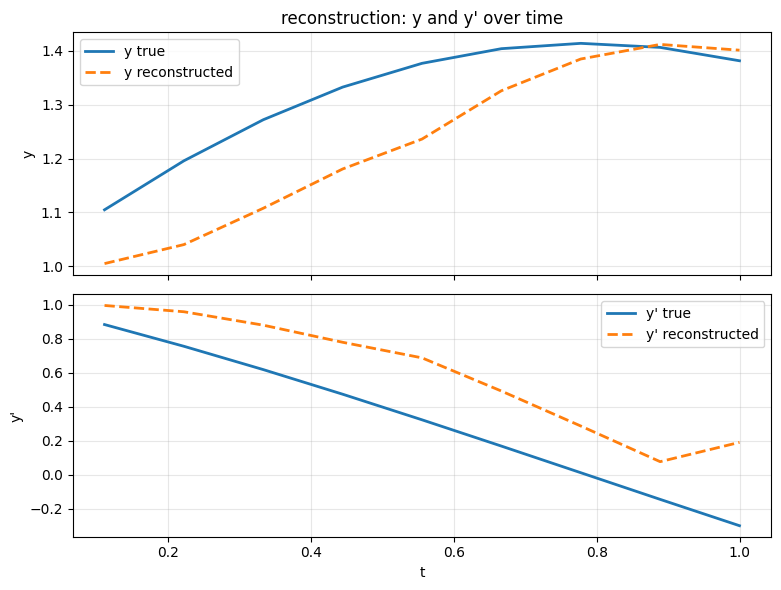

In [68]:
plot_reconstruction(results)

#### Error results

Absolute errors $\Delta y$ and $\Delta y'$ remain small across the full time interval, indicating stable numerical performance of the algorithm. The derivative component exhibits slightly larger deviations, which is expected from finite-order truncation and measurement noise, but overall errors stay bounded and smooth

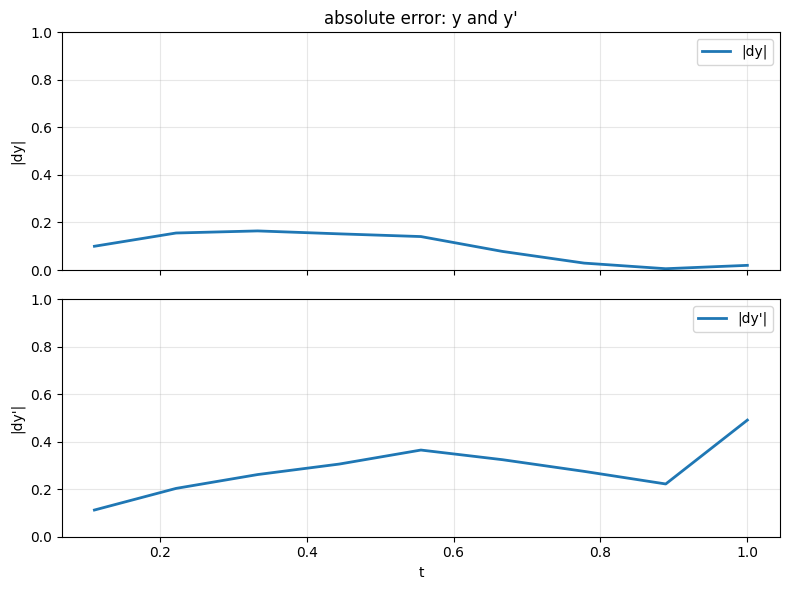

In [69]:
plot_errors(results)

### Energy analysis

This section evaluates the physical consistency of the reconstructed solution by comparing kinetic, potential, and total energy over time

Energies are computed from both the quantum-reconstructed and classical trajectories using:

$$E_{k} = \frac{1}{2}v^{2}, \quad E_{p} = \frac{1}{2}x^{2}, \quad E = E_{k} + E_{p}$$

where $x = y(t)$ and $v = y'(t)$

* `plot_energies()` - visualises all three quantities on the subplots, showing how closely the reconstructed energies follow the true classical ones and validating overall energy conservation throughout the evolution

In [58]:
ke_func=lambda v:0.5*(v**2)  #kinetic energy
pe_func=lambda x:0.5*(x**2)  #potential energy
e_func=lambda x,v:ke_func(v)+pe_func(x)  #total energy

def plot_energies(results, title_prefix="energies"):
    #unpack arrays from unified helper for clean reuse
    t_vals,y_q,yq_prime,y_true,yp_true,_,_=_as_arrays(results)

    #compute energies from reconstructed and classical solutions
    ke_q=ke_func(yq_prime)  #quantum kinetic energy
    pe_q=pe_func(y_q)  #quantum potential energy
    e_q=e_func(y_q,yq_prime)  #quantum total energy

    ke_true=ke_func(yp_true)  #classical kinetic energy
    pe_true=pe_func(y_true)  #classical potential energy
    e_true=e_func(y_true,yp_true)  #classical total energy

    fig,axs=plt.subplots(3,1,figsize=(8,9),sharex=True)  #three stacked subplots for clarity

    axs[0].plot(t_vals,ke_true,linewidth=2,label="ke true")  #classical ke
    axs[0].plot(t_vals,ke_q,linewidth=2,linestyle="--",label="ke reconstructed")  #quantum ke
    axs[0].set_ylabel("ke")  #axis label
    axs[0].set_title(f"{title_prefix}: ke, pe, and total energy over time")  #concise title
    axs[0].grid(True,alpha=0.3)  #soft grid
    axs[0].legend()

    axs[1].plot(t_vals,pe_true,linewidth=2,label="pe true")  #classical pe
    axs[1].plot(t_vals,pe_q,linewidth=2,linestyle="--",label="pe reconstructed")  #quantum pe
    axs[1].set_ylabel("pe")  #axis label
    axs[1].grid(True,alpha=0.3)
    axs[1].legend()

    axs[2].plot(t_vals,e_true,linewidth=2,label="e true")  #classical total
    axs[2].plot(t_vals,e_q,linewidth=2,linestyle="--",label="e reconstructed")  #quantum total
    axs[2].set_xlabel("t")  #shared x label
    axs[2].set_ylabel("e")  #axis label
    axs[2].grid(True,alpha=0.3)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

#### Energy results

The reconstructed kinetic and potential energy curves align well with the classical values, and their complementary evolution confirms physical consistency. The total energy remains effectively constant at unity, validating conservation of energy and confirming that the quantum approximation preserves the system’s underlying harmonic dynamics

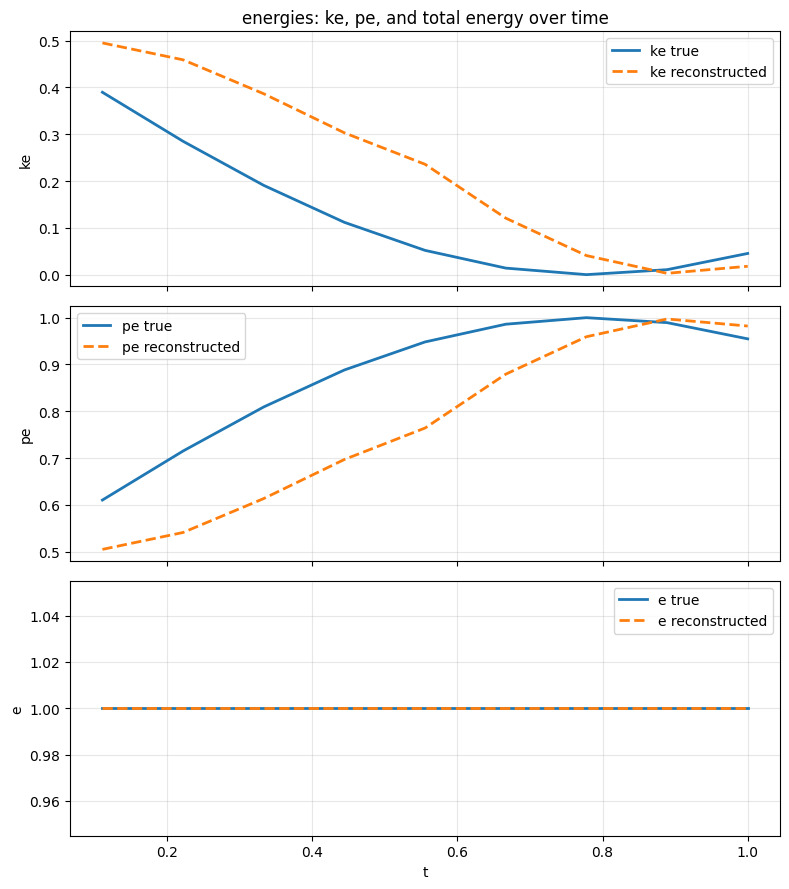

In [70]:
plot_energies(results)

### Bounds experimenting

Here we test how different amplitude bounds affect reconstruction accuracy and circuit performance.
For each bound value, the circuit is resynthesised with updated Taylor amplitudes and executed across all sampled time steps.

* `run_bound_experiments()` - collects results for each bound
* `plot_bound_comparisons()` - visualises their corresponding reconstructions, errors, and energy trends, allowing direct comparison of numerical stability and fidelity under varying bounds for state preperation

In [46]:
#experimenting with different bounds
#helper to run experiments over multiple bounds and collect labelled results
def run_bound_experiments(bounds, shots=32000, show_circ=False):
    global curr_bound, v_amps, b_amps #import global variable so curr_bound, v_amps and b_amps actually gets updated

    #list to hold all results for each bound
    all_results = []

    for i, b in enumerate(bounds):
        curr_bound = b  #update global variable used in circuit synthesis
        print(f"\n========== running experiments for bound = {curr_bound:.4e} ==========\n")

        #container for this bound's time-sweep results
        bound_results = []

        for t_now in range(len(t)):
            if t_now == 0:
                continue #skip t - 0.0
            print(f"for t={t[t_now]:.3f}")
            #update global amplitude lists for current t
            unpadded_vt_amps = list(tv_experiments_amplitudes[t_now][0])
            unpadded_bt_amps = list(tb_experiments_amplitudes[t_now][0])
            v_amps, b_amps = pad_taylor_amplitudes(unpadded_vt_amps, unpadded_bt_amps, taylor_qubits)

            #run circuit for this t and bound
            res_tuple = execute_and_measure(main_qfunc=main, t_i=t_now, shots=shots, show_circ=show_circ, print_reconstruction_only=True)
            bound_results.append(res_tuple)
            print("\n")

        #append tuple with (bound value, results list)
        all_results.append((curr_bound, bound_results))

    return all_results


def plotly_bounds_reconstruction(all_results):
    fig_y = go.Figure()
    fig_yprime = go.Figure()

    # add true analytical curve (same across bounds)
    first_bound = all_results[0][1]
    t_vals, _, _, y_true, yp_true, _, _ = _as_arrays(first_bound)
    fig_y.add_trace(go.Scatter(x=t_vals, y=y_true, mode='lines', name='y true', line=dict(width=3)))
    fig_yprime.add_trace(go.Scatter(x=t_vals, y=yp_true, mode='lines', name="y' true", line=dict(width=3)))

    # add reconstructed curves for each bound
    for curr_bound, bound_results in all_results:
        t_vals, y_q, yq_prime, _, _, _, _ = _as_arrays(bound_results)
        label = f"bound={curr_bound:.1e}"
        fig_y.add_trace(go.Scatter(x=t_vals, y=y_q, mode='lines', name=f'y recon ({label})'))
        fig_yprime.add_trace(go.Scatter(x=t_vals, y=yq_prime, mode='lines', name=f"y' recon ({label})"))

    # layout styling
    fig_y.update_layout(title="Reconstruction: y(t) across bounds",
                        xaxis_title="t", yaxis_title="y",
                        legend_title="Traces", template="plotly_dark")
    fig_yprime.update_layout(title="Reconstruction: y'(t) across bounds",
                             xaxis_title="t", yaxis_title="y'",
                             legend_title="Traces", template="plotly_dark")

    fig_y.show()
    fig_yprime.show()


def plotly_bounds_errors(all_results):
    fig_dy = go.Figure()
    fig_dyprime = go.Figure()

    for curr_bound, bound_results in all_results:
        t_vals, _, _, _, _, dy, dy_prime = _as_arrays(bound_results)
        label = f"bound={curr_bound:.1e}"
        fig_dy.add_trace(go.Scatter(x=t_vals, y=dy, mode='lines', name=f'|dy| ({label})'))
        fig_dyprime.add_trace(go.Scatter(x=t_vals, y=dy_prime, mode='lines', name=f"|dy'| ({label})"))

    fig_dy.update_layout(title="Absolute Error |dy| across bounds",
                         xaxis_title="t", yaxis_title="|dy|",
                         legend_title="Bounds", template="plotly_dark")
    fig_dyprime.update_layout(title="Absolute Error |dy'| across bounds",
                              xaxis_title="t", yaxis_title="|dy'|",
                              legend_title="Bounds", template="plotly_dark")

    fig_dy.show()
    fig_dyprime.show()


def plotly_bounds_energies(all_results):
    fig_ke = go.Figure()
    fig_pe = go.Figure()
    fig_e = go.Figure()

    # true energy reference (same across bounds)
    first_bound = all_results[0][1]
    t_vals, y_q, yq_prime, y_true, yp_true, _, _ = _as_arrays(first_bound)
    ke_true = 0.5 * (yp_true ** 2)
    pe_true = 0.5 * (y_true ** 2)
    e_true = ke_true + pe_true

    fig_ke.add_trace(go.Scatter(x=t_vals, y=ke_true, mode='lines', name='ke true', line=dict(width=3)))
    fig_pe.add_trace(go.Scatter(x=t_vals, y=pe_true, mode='lines', name='pe true', line=dict(width=3)))
    fig_e.add_trace(go.Scatter(x=t_vals, y=e_true, mode='lines', name='e true', line=dict(width=3)))

    # reconstructed energies per bound
    for curr_bound, bound_results in all_results:
        t_vals, y_q, yq_prime, _, _, _, _ = _as_arrays(bound_results)
        ke_q = 0.5 * (yq_prime ** 2)
        pe_q = 0.5 * (y_q ** 2)
        e_q = ke_q + pe_q
        label = f"bound={curr_bound:.1e}"

        fig_ke.add_trace(go.Scatter(x=t_vals, y=ke_q, mode='lines', name=f'ke recon ({label})'))
        fig_pe.add_trace(go.Scatter(x=t_vals, y=pe_q, mode='lines', name=f'pe recon ({label})'))
        fig_e.add_trace(go.Scatter(x=t_vals, y=e_q, mode='lines', name=f'e recon ({label})'))

    fig_ke.update_layout(title="Kinetic Energy across bounds",
                         xaxis_title="t", yaxis_title="ke",
                         legend_title="Bounds", template="plotly_dark")
    fig_pe.update_layout(title="Potential Energy across bounds",
                         xaxis_title="t", yaxis_title="pe",
                         legend_title="Bounds", template="plotly_dark")
    fig_e.update_layout(title="Total Energy across bounds",
                        xaxis_title="t", yaxis_title="e",
                        legend_title="Bounds", template="plotly_dark")

    fig_ke.show()
    fig_pe.show()
    fig_e.show()


def plot_bound_comparisons(all_results):
    plotly_bounds_reconstruction(all_results)
    plotly_bounds_errors(all_results)
    plotly_bounds_energies(all_results)

In [47]:
all_bound_results = run_bound_experiments(bounds, shots=32000, show_circ=False)


========== running experiments for bound = 0.0000e+00 ==========

for t=0.111
Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=32000, success shots=31166
conditional probabilities: P0=0.511872, P1=0.488128
scaling factor: C=1.414214, t=0.111
reconstructed y(t) = 1.011802, y'(t) = 0.988057
classical true y(t) = 1.104716, y'(t) = 0.882951
absolute errors: dy = 9.291387e-02, dy' = 1.051059e-01


for t=0.222
Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=32000, success shots=29084
conditional probabilities: P0=0.549581, P1=0.450419
scaling factor: C=1.414214, t=0.222
reconstructed y(t) = 1.048409, y'(t) = 0.949125
classical true y(t) = 1.195808, y'(t) = 0.755012
absolute errors: dy = 1.473990e-01, dy' = 1.941130e-01


for t=0.333
Circuit Constructed...executing now
executed!


----measurement reconstruction validation----
shots=32000, success shots=25856
conditional probabilities: P0=0.

* Across all plots, the bounds $\set{0, 0.001, 0.01, 0.05, 0.1}$ have a stable curve that approximates the analytical solutions with very slight deviations, but carrying the same lag in amplitude as our original result.

* The bounds $\set{0.25, 0.5}$ show varied deviations with `curr_bound=0.25` initially lagging behind but stabilises itself after $t=0.5$; and `curr_bound=0.5` showing significant deviation across all timesteps except for $t=1$


**Please note: `e_true` on the total energy plot is constant, the slight oscillations are just floating-point rounding/precision issues with the plot function auto-scaling to the axis**


*click on the keys on the graph to view selected trajectories*


In [48]:
plot_bound_comparisons(all_bound_results)

### Classical Solver vs Quantum Approximator

We compare the quantum reconstruction with three classical approximation methods for our HO example $y''+y=0$ under $y(0)=1, y'(0)=1$

Euler's method computes discrete updates using a fixed step size $h$:
$$y_{n+1} = y_{n} + h y'_{n}, \quad y'_{n+1} = y'_{n} - h y_{n}$$

The taylor series is the classical equivalent of the quantum implementation with:
$$y(t) \approx y_{0} \cos_{k}(t) + y'_{0} \sin_{k}(t), \quad y'(t) \approx -y_{0} \sin_{k}(t) + y'_{0} \cos_{k}(t)$$

~and the RK45 (adaptive Runge-Kutta) solver built-in from `scipy`

In [27]:
## euler's method
def solver_euler(t, y0=1.0, y_prime0=1.0):
    # fixed-step explicit euler for y'' + y = 0
    h = t[1] - t[0]
    y, y_prime = y0, y_prime0
    y_vals, y_prime_vals = [y], [y_prime]
    for _ in range(1, len(t)):
        y_new = y + h * y_prime
        y_prime_new = y_prime - h * y
        y, y_prime = y_new, y_prime_new
        y_vals.append(y)
        y_prime_vals.append(y_prime)
    return y_vals, y_prime_vals

# truncated taylor series (order up to 64) consistent for y and y'
def solver_taylor(t, y0=1.0, y_prime0=1.0, order=64):
    # build truncated cos_k and sin_k then combine linearly
    def cos_sin_trunc(ti, k):
        cos_k = 0.0
        sin_k = 0.0
        # cos terms up to floor(k/2)
        jmax_cos = k // 2
        for j in range(jmax_cos + 1):
            cos_k += ((-1) ** j) * (ti ** (2 * j)) / math.factorial(2 * j)
        # sin terms up to floor((k-1)/2)
        jmax_sin = (k - 1) // 2
        for j in range(jmax_sin + 1):
            sin_k += ((-1) ** j) * (ti ** (2 * j + 1)) / math.factorial(2 * j + 1)
        return cos_k, sin_k

    y_vals = []
    y_prime_vals = []
    for ti in t:
        cos_k, sin_k = cos_sin_trunc(ti, order)
        y_t = y0 * cos_k + y_prime0 * sin_k
        y_prime_t = -y0 * sin_k + y_prime0 * cos_k
        y_vals.append(y_t)
        y_prime_vals.append(y_prime_t)
    return y_vals, y_prime_vals

# derivatives for rk solver
def sho_derivatives(t, v):
    # v = [y, y']
    y, y_prime = v
    return [y_prime, -y]

# runge–kutta (rk45) via scipy
def solver_rk45(t, y0=1.0, y_prime0=1.0):
    sol = solve_ivp(
        sho_derivatives,
        (t[0], t[-1]),
        [y0, y_prime0],
        t_eval=t,
        method='RK45'
    )
    y_vals = sol.y[0].tolist()
    y_prime_vals = sol.y[1].tolist()
    return y_vals, y_prime_vals


def plotly_compare_solvers(results, t, y_euler, yp_euler, y_taylor, yp_taylor, y_rk, yp_rk, title_prefix="reconstruction vs classical solvers"):
   
    # unpack quantum + true arrays from results (these start from t[1:])
    t_vals, y_q, yq_prime, y_true, yp_true, _, _ = _as_arrays(results)

    #align classical arrays to the same indices used in `results` (skip t[0])
    # ind indices in t corresponding to t_vals (assumes t_vals == t[1:])
    idx_map = {np.round(tv, 12): i for i, tv in enumerate(np.round(t, 12))}
    sel_idx = [idx_map[np.round(tv, 12)] for tv in np.round(t_vals, 12)]

    y_eu_sel   = np.array(y_euler)[sel_idx]
    yp_eu_sel  = np.array(yp_euler)[sel_idx]
    y_tay_sel  = np.array(y_taylor)[sel_idx]
    yp_tay_sel = np.array(yp_taylor)[sel_idx]
    y_rk_sel   = np.array(y_rk)[sel_idx]
    yp_rk_sel  = np.array(yp_rk)[sel_idx]

    # two linked subplots: y(t) and y'(t)
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        subplot_titles=("y(t) comparison", "y'(t) comparison"))

    #true (always on)
    fig.add_trace(go.Scatter(x=t_vals, y=y_true, mode='lines', name='y true', line=dict(width=3)),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t_vals, y=yp_true, mode='lines', name="y' true", line=dict(width=3)),
                  row=2, col=1)

    #uantum reconstruction
    fig.add_trace(go.Scatter(x=t_vals, y=y_q, mode='lines', name='y recon (quantum)', line=dict(dash='dash')),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t_vals, y=yq_prime, mode='lines', name="y' recon (quantum)", line=dict(dash='dash')),
                  row=2, col=1)

    #classical solvers
    fig.add_trace(go.Scatter(x=t_vals, y=y_eu_sel, mode='lines', name='y Euler'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t_vals, y=yp_eu_sel, mode='lines', name="y' Euler"),
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=t_vals, y=y_tay_sel, mode='lines', name='y Taylor'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t_vals, y=yp_tay_sel, mode='lines', name="y' Taylor"),
                  row=2, col=1)

    fig.add_trace(go.Scatter(x=t_vals, y=y_rk_sel, mode='lines', name='y RK45'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=t_vals, y=yp_rk_sel, mode='lines', name="y' RK45"),
                  row=2, col=1)

    fig.update_layout(
        title=title_prefix,
        legend_title="Traces (toggle on/off)",
        hovermode="x unified",
        template="plotly_dark",
        margin=dict(l=60, r=40, t=80, b=60),
        height=650
    )
    fig.update_xaxes(title_text="t", row=2, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)
    fig.update_yaxes(title_text="y'", row=2, col=1)

    fig.show()

The classical solvers closely track the analytic trajectory of the harmonic oscillator, with Euler’s method showing a slight overshoot in $y(t)$ due to its first-order truncation. Both the Taylor and RK45 solutions remain almost indistinguishable from the true curve, confirming their higher precision.

The quantum reconstruction reproduces the overall oscillatory trend but underestimates the amplitude across the interval. This indicates that, for **this simple system**, classical solvers remain superior in both accuracy and efficiency, while the quantum method serves mainly as a proof-of-principle demonstration of the algorithm’s correctness rather than a performance advantage; to truly evaluate the quantum advantage, the algorithm would need to be tested on a higher dimensional or more complex system, where classical approximations become costly


*click on the keys on the graph to view selected trajectories*

In [45]:
y_euler, yp_euler = solver_euler(t)
y_taylor, yp_taylor = solver_taylor(t)
y_rk, yp_rk = solver_rk45(t)

plotly_compare_solvers(results, t, y_euler, yp_euler, y_taylor, yp_taylor, y_rk, yp_rk)

### Circuit Optimisation

The synthesis results show that increasing the maximum width constraint (available qubits) quickly reduces the circuit depth until about 15 qubits, after which the depth stabilizes below 1400 layers, with 10 qubits reachning a minimal of **1363 layers**

This indicates that once sufficient qubit resources are available, the compiler can fully parallelise operations in the LDE circuit, and further width expansion no longer yields optimization gains. The plateau past 15 qubits suggests the circuit has reached its minimal effective depth, constrained by the intrinsic gate structure of the algorithm, rather than by qubit availability

In [31]:
# list of width constraint values to sweep
width_constraints = [8, 9, 10, 15, 18, 19, 20] #for truncation order k=8

# store resulting widths and depths
widths = []
depths = []

# loop over different max widtrh constraints
for max_width in width_constraints:
    # print(f"\n=== synthesizing for max_width = {max_width} ===")
    
    # set constraint to optimize for width under depth limit
    qmod_constrained = set_constraints(
        create_model(main),
        Constraints(optimization_parameter="depth", max_width=max_width)
    )

    # synthesize circuit under current depth constraint
    qprog = synthesize(qmod_constrained)
    # print("synthesized!")

    # record resulting width and actual circuit depth
    widths.append(qprog.data.width)
    depths.append(qprog.transpiled_circuit.depth)

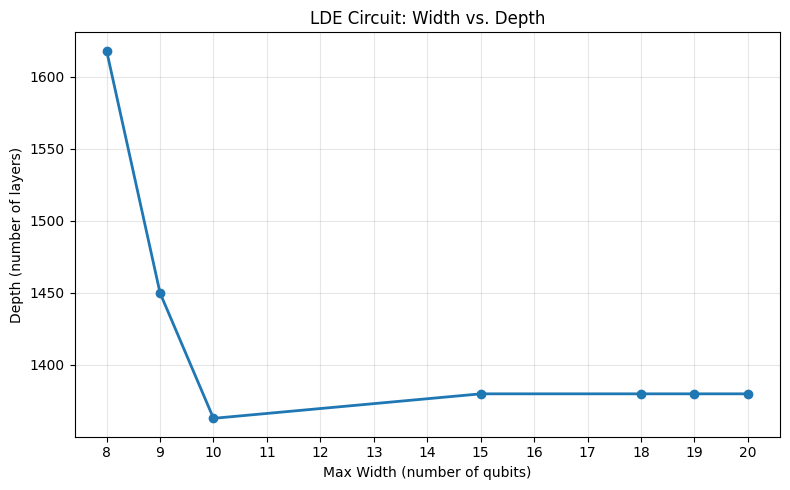

In [32]:
# plot depth results vs constraint setting
plt.figure(figsize=(8, 5))
plt.plot(widths, depths, marker='o', linewidth=2)
plt.xlabel("Max Width (number of qubits)")
plt.xticks(range(min(widths), max(widths)+1))
plt.ylabel("Depth (number of layers)")
plt.title("LDE Circuit: Width vs. Depth")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
print(min(depths))

1363


Given the width-depth plateau, for our specific LDE, we can actually further optimise the efficiency and accuracy of the approximation using a single qubit and 2 gate circuit.

**Circuit**


Recall that our system matrix is $M =\begin{bmatrix} 0&1 \\ -1&0 \end{bmatrix}$, this is equivalent to the unitary $iY$, and since $b=0$, we can simplify our evolution as:

$$v(t) = e^{Mt}v(0) = e^{iY}v(0) = R_{Y}(2t)v(0)$$

with initial conditions $y(0), y'(0) = 1$, so the normalised state is:

$$v(0) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = |+\rangle$$

~we can prepare $v(0)$ with a single Hadamard transform. Our full circuit is then:

$$|v(t)\rangle = R_{Y}(2t)H|0\rangle$$

-------

**Reconstruction**

Using $R_{Y}(2t) = \begin{bmatrix} \cos(2t)& -\sin(2t) \\ \sin(2t)& \cos(2t) \end{bmatrix}$, gives:

$$|v(t)\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} \cos(2t)& -\sin(2t) \\ \sin(2t)& \cos(2t) \end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix} y'(t) \\ y(t) \end{bmatrix} $$

~hence the computational basis carries the approximations in reverse order, but the reconstruction method and scaling remain the same, just without any post selection and swapped indexing

In [71]:
t_temp = 0.1 #global placeholder for this circuit

@qfunc 
def main(work: Output[QBit]):
    allocate(work) #initialise
    # inplace_prepare_amplitudes(amplitudes=v0_normalised.tolist(), bound=curr_bound, target=work) #prep IC state
    H(work) #can simplify IC state prep as simple hadamard gate
    RY(theta=(2*t_temp), target=work) #simple RY rotation to approximate

def reconstruct_simple(res, C):
    counts = res.counts
    total = sum(counts.values())
    p0 = counts.get('0', 0) / total
    p1 = counts.get('1', 0) / total
    # recover amplitudes from probabilities (normalised)
    alpha = np.sqrt(p0)
    beta  = np.sqrt(p1)
    # scale by the same norm C used for v(0)
    return C * np.array([alpha, beta])

In [40]:
_ = run_measurement_execution(main, show_circ=True, run=False) #view circuit

Circuit Constructed...executing now
Quantum program link: https://platform.classiq.io/circuit/34Q0v1GzevvWTywgow90uMJDFna


https://platform.classiq.io/circuit/34Q0v1GzevvWTywgow90uMJDFna?login=True&version=14

executed!


In [72]:
optimised_circuit_results = []

for i, t_now in enumerate(t):
    if i == 0:
        continue 
    t_temp = t_now #update global variable
    res = run_measurement_execution(main, show_circ=False, run=True)
    v_t = reconstruct_simple(res, v0_norm_factor) #still scaled by norm factor
    optimised_circuit_results.append((t_now, v_t[1], v_t[0])) #store y(t), y'(t)

Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!
Circuit Constructed...executing now
executed!


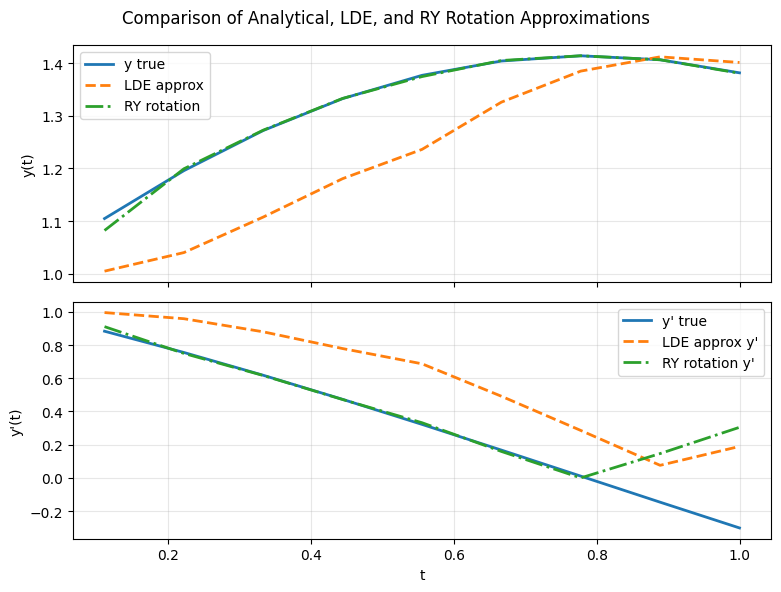

In [73]:
t_ry = np.array([r[0] for r in optimised_circuit_results])
y_ry = np.array([r[1] for r in optimised_circuit_results])
yp_ry = np.array([r[2] for r in optimised_circuit_results])

t_vals, y_q, yq_prime, y_true, yp_true, _, _ = _as_arrays(results) #using original algorithm results

#plot for comparison
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# y(t)
axs[0].plot(t_vals, y_true, label='y true', linewidth=2)
axs[0].plot(t_vals, y_q, '--', label='LDE approx', linewidth=2)
axs[0].plot(t_ry, y_ry, '-.', label='RY rotation', linewidth=2)
axs[0].set_ylabel('y(t)')
axs[0].legend()
axs[0].grid(alpha=0.3)

# y'(t)
axs[1].plot(t_vals, yp_true, label="y' true", linewidth=2)
axs[1].plot(t_vals, yq_prime, '--', label="LDE approx y'", linewidth=2)
axs[1].plot(t_ry, yp_ry, '-.', label="RY rotation y'", linewidth=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel("y'(t)")
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.suptitle("Comparison of Analytical, LDE, and RY Rotation Approximations")
plt.tight_layout()
plt.show()